# Visual Search Tutorial

The purpose of visual search is to allow a user to submit any image, and then get results that look "similar" to that input. What exactly "similar" means determines the type of model used. This tutorial has three steps.
1. Check out the data
2. Run CLIP over the images in the dataset
3. Create a kNN index that can be searched
4. An experience for our users!

## 1. Check out the data

We'll import all the necessary packages and see what the `styles.csv` index contains.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import time

/Users/christophermiller/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [1]:
filename = "./myntradataset/styles.csv"
df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas

available_ids = os.listdir("./myntradataset/images")
available_ids = [int(x.replace(".jpg","")) for x in available_ids]
df = df[df.id.isin(available_ids)] #some images are not actually available
df = df.dropna(subset='productDisplayName')


df.head()

NameError: name 'pd' is not defined

The column `id` indicates the filename of the image, while `productDisplayName` is the product title. Here's some code that will help us display images.

In [3]:
def display_images_and_titles(filepaths, titles):
    # Create a 4x5 grid of subplots
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

    


Let's display some random images from the dataset

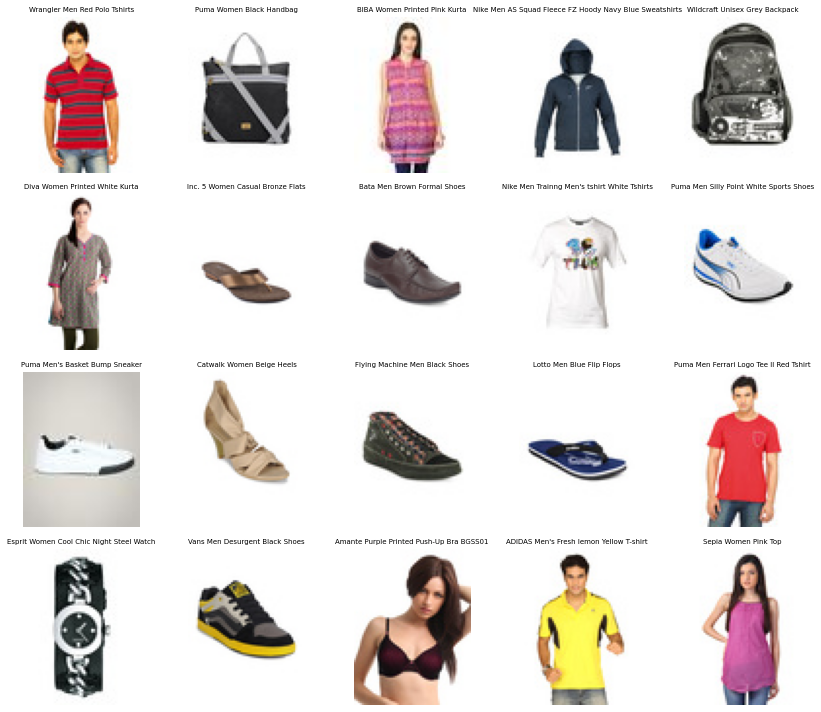

In [5]:
# You'll need to change this
directory = "/Users/christophermiller/Documents/IMA/2023/myntradataset/images/"

# Display 20 random images
random_subset = df.iloc[np.random.randint(0,df.shape[0], size = 20)]
filenames = random_subset.id.astype(str).tolist()
filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
titles = random_subset.productDisplayName.tolist()

display_images_and_titles(filepaths, titles)

## 2. Let's create an embedding for each of these

First we'll download a model (CLIP) for embedding. After you run this one time, it will be cached on your computer for future use.

In [6]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

CLIP is actually two models train in tandem: an image encoder and a text encoder. The two models play well together and are often used for selecting labels from a limited list of options. Here we'll take a random image and two three labels. We'll ask CLIP which one it thinks is best.

a photo of a man in a shirt. probability:0.6737


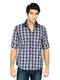

In [9]:
sample_image_path = "./myntradataset/images/15970.jpg"
image = Image.open(sample_image_path)
text=["a photo of a shirt", "a photo of a dress", "a photo of a shoe", "a photo of a man in a shirt"]

inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print(f"{text[probs.argmax()]}. probability:{probs[0][probs.argmax()]:0.4f}")
image

Great, CLIP correctly thinks this is a photo of a shirt instead o a dress or a shoe. CLIP was trained on captions, so it works best with titles that start with "a photo of" or "a title of"

In the backgound of the task above, CLIP is actually producing an embedding vector for the image, and an embedding vector for each of the lines of text. 

In [10]:
print("image embedding(s) shape:", outputs.image_embeds.shape)
print("text embedding(s) shape:", outputs.text_embeds.shape)

image embedding(s) shape: torch.Size([1, 512])
text embedding(s) shape: torch.Size([4, 512])


Then the pairwise dot products are computed, and a probability distribution over titles is derived using softmax. 

This framework is flexible. Think of the above as "image-text" search, we can also do "text-image", "image-image" or "text-text" search as well.

## 3. Now we infer embeddings

We'll iterate through the dataset (in batches) and run inference over every image and every title. The titles are not relevant for the tutorial, but perhaps you'll want them later.

In [ ]:
# Directory path containing the images
image_dir = './myntradataset/images'

filenames = df.id.astype(str).apply(lambda x : x + ".jpg").tolist()
titles = df.productDisplayName.tolist()
image_files = [os.path.join(image_dir, filename) for filename in filenames]



# Iterate over the images in the directory in batches
image_embeddings = []
title_embeddings = []

batch_size = 100
tic = time.time()
for i in range(0, len(image_files), batch_size):
    batch_files = image_files[i:i+batch_size]
    batch_titles = titles[i:i+batch_size]

    # Load and preprocess batch of images
    images = []
    for image_file in batch_files:
        image = Image.open(image_file)
        images.append(image)
        
    input_batch = processor(text=batch_titles, images=images, return_tensors="pt", padding=True)


    # Perform inference
    with torch.no_grad():
        output = model(**input_batch)

    # Process the model output as per your use case
    # For example, retrieve the predicted label
    image_embeddings.append(output.image_embeds)
    title_embeddings.append(output.text_embeds)

    if i % 1000 == 0:
        toc = time.time()
        print(i, toc - tic)
        tic = toc

torch.save(torch.cat(image_embeddings, dim=0), 'image_tensor.pt')
torch.save(torch.cat(title_embeddings, dim=0), 'title_tensor.pt')



The output is saved in two .pt files. I will also provide these to you so you needn't wait for this cell to run.

## Let's do kNN over the results

Here we will create a searchable vector index. The idea is that you can plug in a query vector (e.g. an image) and see nearby vectors (images). You're probably familiar with kNN as a suprvides learning task. Here we will just use it as a lookup! So our labels will be the `id`s of the corresponding images.

In [11]:
knn_vectors = torch.load("image_tensor.pt")
knn_labels = df.id.astype(str).tolist()

`faiss` is a useful package, made by Meta AI Research (formerly FAIR). You can easily create or combine indexes. Here we will use a very deliberate, simply index. For the larger dataset, you made need to use clustering, PQ encodings or HNSW. All of these are possible with `faiss`. 

In [12]:
import faiss

# Convert data to numpy arrays for use with faiss
vectors_np = knn_vectors.numpy()

# Build the index
dimension = vectors_np.shape[1]  # Dimension of the vectors
index = faiss.IndexFlatL2(dimension)
index.add(vectors_np)

Now we want to query the dataset. In general, users will want to submit their own images. For now, let's take one from our own dataset, because we already have an embedding for it.

In [15]:
# Select a query vector
query_vector = vectors_np[28347].reshape(1, -1)

# Query the index
k = 20  # Number of neighbors to return
D, I = index.search(query_vector, k)

# `I` now contains the indices of the 10 nearest neighbors to the first vector
# `D` contains the corresponding squared L2 distances

# Get labels of the neighbors
neighbor_labels = [knn_labels[i] for i in I[0]]

And we'll display the results here. Since our query image has L2 distance == 0 with itself, it will be the first result.

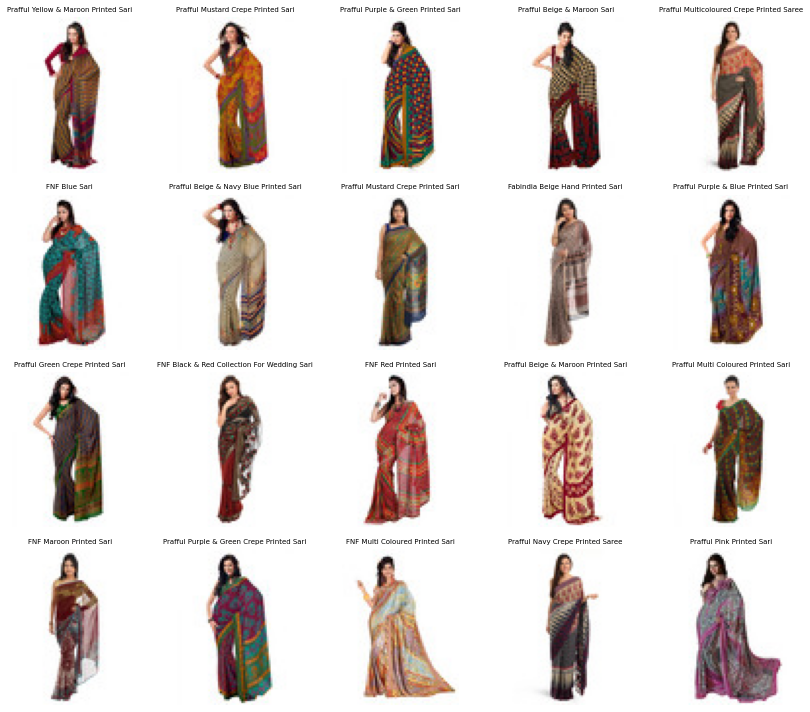

In [16]:
directory = "/Users/christophermiller/Documents/IMA/2023/myntradataset/images/"
display_images_titles_from_ids(neighbor_labels, directory)

## 4. An experience for our users!

I haven't given you code for supporting users' own queries. Try writing your own next. Your code will have to
1. Allow any image to be brought in.
2. Run inference over the image.
3. Submit the image to the index.
4. Display the results.

In [ ]:
local_picture = "/path/path.jpg"
...
output = model(picture)
...
results = index.search(output.vector)
display(results)
